In [2]:
import sys
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import numpy as np
import glob as glb
from shapely.geometry import box
from shapely.geometry import Polygon
from shapely.geometry import Point
import shapely.wkt
# from datetimerange import DateTimeRange
import datetime as dt
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
import numpy as np

In [3]:
from scipy.spatial import distance as dist
from scipy.spatial.distance import cdist

In [4]:
from shapely.geometry import MultiPoint

In [5]:
import math
from sklearn.metrics import silhouette_score

In [6]:
from sklearn.cluster import KMeans


In [7]:
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#get noaa_file
def get_noaa_ar_df(file_path):
    noaa_ar = pd.read_csv(file_path)
    noaa_ar = noaa_ar.rename(columns={'Unnamed: 0': 'id'})
    noaa_ar = noaa_ar.set_index("id")
    noaa_ar['year'] = noaa_ar['year'].astype(str)
    noaa_ar['month'] = noaa_ar['month'].astype(str)
    noaa_ar['day'] = noaa_ar['day'].astype(str)
    noaa_ar['ar_time'] = pd.to_datetime(noaa_ar[['year', 'month', 'day']].apply(lambda x: '-'.join(x), axis=1))
#     noaa_ar['Datetime_st_time'] = noaa_ar['ar_time'].apply(lambda row: row - dt.timedelta(hours = 12))
#     noaa_ar['Datetime_ed_time'] = noaa_ar['ar_time'].apply(lambda row: row + dt.timedelta(hours = 12))
    noaa_ar['longitude'] = noaa_ar['central_meridian_dist'].astype(float)
    noaa_ar['latitude'] = noaa_ar['latitude'].astype(float)
    
    
    df = noaa_ar[['ar_time','noaa_ar_no','longitude','latitude','corr_whole_spot_area','mcintosh','LL','number_of_spots','greenwich']]
    df = df.sort_values(by=['ar_time','noaa_ar_no']).reset_index(drop=True)
    
    return df

In [24]:
noaa_path = r'./Data/NOAA Data/1996_2019_noaa_ars_plages.csv'
noaa_df = get_noaa_ar_df(noaa_path)

In [25]:
noaa_df['noaa_ar_no'] = noaa_df['noaa_ar_no'].apply(lambda x: x-10000 if x>12747 else x) #adjust noaa_ar_no

In [26]:
noaa_df['ar_time'] = noaa_df['ar_time'].apply(lambda x: pd.Timestamp.to_datetime64(x))

In [27]:
noaa_df

ar_time  noaa_ar_no  longitude  latitude  corr_whole_spot_area  \
0     1996-01-02        7933       76.0     -12.0                   NaN   
1     1996-01-02        7934       53.0      -4.0                   NaN   
2     1996-01-02        7935        6.0      11.0                  10.0   
3     1996-01-02        7937      -49.0      -9.0                   0.0   
4     1996-01-03        7933       89.0     -12.0                   NaN   
...          ...         ...        ...       ...                   ...   
45332 2019-08-11       12747       48.0       6.0                   NaN   
45333 2019-08-12       12746       82.0      -5.0                   NaN   
45334 2019-08-12       12747       63.0       6.0                   NaN   
45335 2019-08-13       12747       78.0       6.0                   NaN   
45336 2019-08-14       12747       93.0       6.0                   NaN   

      mcintosh   LL  number_of_spots greenwich  
0         None  NaN              NaN     Plage  
1         None  NaN              NaN     Plage  
2          BXO  8.0              4.0      BETA  
3          AXX  1.0              1.0     ALPHA  
4         None  NaN              NaN     Plage  
...        ...  ...              ...       ...  
45332     None  NaN              NaN     Plage  
45333     None  NaN              NaN     Plage  
45334     None  NaN              NaN     Plage  
45335     None  NaN              NaN     Plage  
45336     None  NaN              NaN     Plage  

[45337 rows x 9 columns]

In [13]:
noaa_num_trj = pd.merge(noaa_df,(noaa_df.noaa_ar_no.value_counts() >=2).sort_index().to_frame(name = 'traj_ge_2').reset_index().rename(columns={'index': 'noaa_ar_no'}),left_on=['noaa_ar_no'],right_on = ['noaa_ar_no'],how = 'outer')
noaa_num_trj.head()

ar_time  noaa_ar_no  longitude  latitude  corr_whole_spot_area mcintosh  \
0 1996-01-02        7933       76.0     -12.0                   NaN     None   
1 1996-01-03        7933       89.0     -12.0                   NaN     None   
2 1996-01-02        7934       53.0      -4.0                   NaN     None   
3 1996-01-03        7934       60.0      -8.0                   0.0      AXX   
4 1996-01-04        7934       73.0      -8.0                   NaN     None   

    LL  number_of_spots greenwich  traj_ge_2  
0  NaN              NaN     Plage       True  
1  NaN              NaN     Plage       True  
2  NaN              NaN     Plage       True  
3  0.0              1.0     ALPHA       True  
4  NaN              NaN     Plage       True

In [14]:
len(noaa_num_trj[noaa_num_trj.traj_ge_2 == True].noaa_ar_no.unique())#number of noaa with records at least 2 points

4795

In [15]:
noaa_num_trj[noaa_num_trj.traj_ge_2 == True] #45319 records (points)

ar_time  noaa_ar_no  longitude  latitude  corr_whole_spot_area  \
0     1996-01-02        7933       76.0     -12.0                   NaN   
1     1996-01-03        7933       89.0     -12.0                   NaN   
2     1996-01-02        7934       53.0      -4.0                   NaN   
3     1996-01-03        7934       60.0      -8.0                   0.0   
4     1996-01-04        7934       73.0      -8.0                   NaN   
...          ...         ...        ...       ...                   ...   
45332 2019-08-10       12747       33.0       6.0                   NaN   
45333 2019-08-11       12747       48.0       6.0                   NaN   
45334 2019-08-12       12747       63.0       6.0                   NaN   
45335 2019-08-13       12747       78.0       6.0                   NaN   
45336 2019-08-14       12747       93.0       6.0                   NaN   

      mcintosh   LL  number_of_spots greenwich  traj_ge_2  
0         None  NaN              NaN     Plage       True  
1         None  NaN              NaN     Plage       True  
2         None  NaN              NaN     Plage       True  
3          AXX  0.0              1.0     ALPHA       True  
4         None  NaN              NaN     Plage       True  
...        ...  ...              ...       ...        ...  
45332     None  NaN              NaN     Plage       True  
45333     None  NaN              NaN     Plage       True  
45334     None  NaN              NaN     Plage       True  
45335     None  NaN              NaN     Plage       True  
45336     None  NaN              NaN     Plage       True  

[45319 rows x 10 columns]

In [14]:
# trj_segment_spatial = {}

In [28]:
def trj_interpolate(trj,step):
    
    #By given trajectory and interpolate step, to fill the missing value in trajectory
    
    trj_range = np.arange(trj.index[0],trj.index[-1],dtype='datetime64[{}]'.format(step))
    
#     print("new_range: -------",trj_range)
    
    trj_id = trj.noaa_ar_no.unique()[0]
    
    if len(trj_range) == trj.shape[0]:
        
        return trj, trj_id #return nomal trj and trj_id
    
    else:
        
        idx = trj.index.union(trj_range) #new index
        
#         print("modified_range: ----------",idx.values)
        
        trj = trj.reindex(idx).reset_index(drop=True)
        
        trj['noaa_ar_no'].fillna(method ='ffill',inplace = True) #interpolate noaa number
        
        trj['longitude'] = trj['longitude'].interpolate(method ='linear') #linear interpolate
        
        trj['latitude'] = trj['latitude'].interpolate(method ='linear') #linear interpolate
                                                      
        
                                                                            
        
        return trj,trj_id #return interpolated trj and trj_id
        
        
        
        

In [29]:
def trj_seg_spatial(trj,trj_id):
    
    #Derive feature for trajectory segments
    
    point_list = MultiPoint(list(zip(trj.longitude,trj.latitude)))
    
    v_lon_displace = [j.x - i.x for i,j in zip(point_list[:-1],point_list[1:])] #x displacement
    
    v_lat_displace = [j.y - i.y for i,j in zip(point_list[:-1],point_list[1:])] #y displacement
    
    v_length = [j.distance(i) for i,j in zip(point_list[:-1],point_list[1:])] #vector length
    
    v_angle = [math.degrees(math.atan2(lat,lon)) for lon,lat in zip(v_lon_displace,v_lat_displace)]#vector angle
    
    v_position = [[i.x,i.y,j.x,j.y] for i,j in zip(point_list[:-1],point_list[1:])]
    
    
    
    trj_seg = {'lon_diff': v_lon_displace,'lat_diff':v_lat_displace,'v_length':v_length,'v_angle':v_angle,'v_points':v_position }
    
    trj_seg_df = pd.DataFrame(trj_seg,columns = list(trj_seg.keys()))
    
    trj_seg_df['ar_no'] = trj_id
    
    trj_seg_df['idx'] = trj_seg_df.index.values
    
    
    return trj_seg_df
    
    

In [30]:
def spatial_preprocess(df):
    
    #By given raw trajectory dataframe, output trajectory segments
    
    trj_seg_df_list = []
    
    traj_list = df.noaa_ar_no.unique()
    
    for index, trj_id in enumerate(traj_list):
        
        tem_trj = pd.DataFrame(df[df.noaa_ar_no == trj_id].sort_values(by=['ar_time']).values,columns = df.columns)#retrieve each trajectory by order
        
        tem_trj['longitude'] = tem_trj['longitude'].astype(float)
        tem_trj['latitude'] = tem_trj['latitude'].astype(float)
        
        if tem_trj.shape[0] >1: #choose trajectory with at least two records and 
            
#             print(trj_id)
            
            tem_trj.index = tem_trj['ar_time']
            
            del tem_trj['ar_time']
            
#             print(tem_trj.index.values)
            
            #interpolate process
            
            trj , trj_id_id = trj_interpolate(tem_trj,'D') #interpolation procedure for trajectory
            
            trj_seg = trj_seg_spatial(trj , trj_id_id)#segmentation process based on time_unit
            
            trj_seg_df_list.append(trj_seg)
            
            
    trj_seg_df = pd.concat(trj_seg_df_list).reset_index(drop = True)
    
    return trj_seg_df
        
        

#### Implementation Part

In [63]:
# len(noaa_df.noaa_ar_no.unique())

In [31]:
noaa_test = pd.DataFrame(noaa_df.values,columns = noaa_df.columns)

### Create trajectory segments 

In [32]:
noaa_t = spatial_preprocess(noaa_test)

In [33]:
len(noaa_t.ar_no.unique())

4795

In [34]:
noaa_t.describe() #40758 trajectory segments after linear interpolation

lon_diff      lat_diff      v_length       v_angle         ar_no  \
count  40758.000000  40758.000000  40758.000000  40758.000000  40758.000000   
mean      13.250601      0.014819     13.355442     -0.397872  10361.136390   
std        2.590253      1.397789      2.423627     11.837483   1373.491515   
min     -134.000000    -81.000000      0.000000   -178.667780   7933.000000   
25%       13.000000      0.000000     13.000000      0.000000   9170.000000   
50%       13.000000      0.000000     13.038405      0.000000  10350.500000   
75%       14.000000      0.000000     14.000000      0.000000  11560.000000   
max      145.000000     79.000000    145.773797    180.000000  12747.000000   

                idx  
count  40758.000000  
mean       4.603931  
std        5.202571  
min        0.000000  
25%        2.000000  
50%        4.000000  
75%        7.000000  
max      131.000000

### using MinMaxs Scaler to normalize data

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
mms = MinMaxScaler()
mms.fit(noaa_t[['lon_diff','lat_diff','v_length','v_angle']])
test_data_transformed = mms.transform(noaa_t[['lon_diff','lat_diff','v_length','v_angle']])

In [37]:
test_data_transformed

array([[0.52688172, 0.50625   , 0.08917926, 0.49814282],
       [0.50537634, 0.48125   , 0.05530663, 0.41521125],
       [0.52688172, 0.50625   , 0.08917926, 0.49814282],
       ...,
       [0.53405018, 0.50625   , 0.10289915, 0.49814282],
       [0.53405018, 0.50625   , 0.10289915, 0.49814282],
       [0.53405018, 0.50625   , 0.10289915, 0.49814282]])

#### Select optimal K by using elbow and silhouette score

In [27]:
Sum_of_squared_distances_minmax = []
sil_minmax = []
K = range(2,9)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(test_data_transformed)
    Sum_of_squared_distances_minmax.append(km.inertia_)
    

    labels = km.labels_
    sil_minmax.append(silhouette_score(test_data_transformed, labels, metric = 'euclidean'))

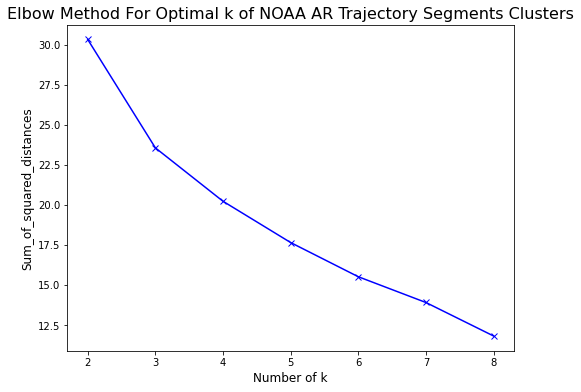

In [28]:
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
plt.figure(figsize = (8,6))
plt.plot(K, Sum_of_squared_distances_minmax, 'bx-')
plt.xlabel('Number of k',fontsize = 12)
plt.ylabel('Sum_of_squared_distances',fontsize = 12)
plt.title('Elbow Method For Optimal k of NOAA AR Trajectory Segments Clusters',fontsize = 16)
# plt.savefig('Elbow for NOAA.png',bbox_inches='tight')
plt.show()

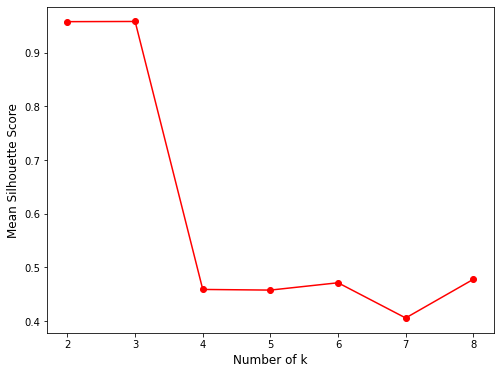

In [29]:
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
plt.figure(figsize = (8,6))
plt.plot(K, sil_minmax, 'ro-')
plt.xlabel('Number of k',fontsize = 12)
plt.ylabel('Mean Silhouette Score',fontsize = 12)
# plt.title('Silhouette_score For Optimal k')
# plt.savefig('Mean Silhouette Coefficient for NOAA.png',bbox_inches='tight')
plt.show()

Text(0, 0.5, 'Mean Silhouette Score')

<Figure size 1080x432 with 0 Axes>

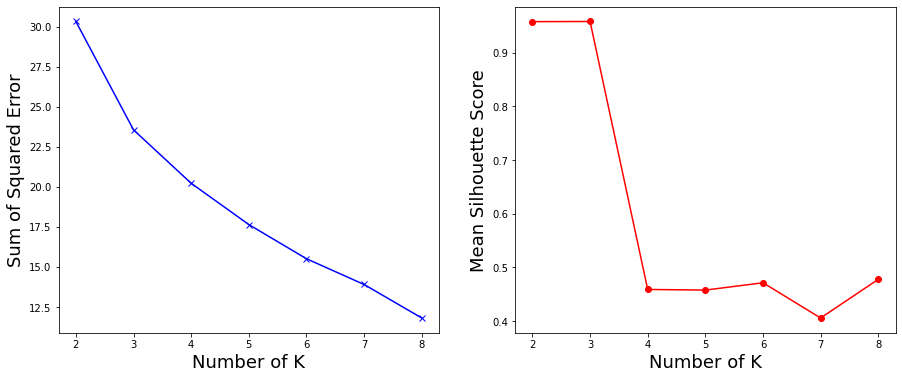

In [30]:

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
fig = plt.figure(figsize=(15, 6))
fig,axes = plt.subplots(1,2,sharex=True,sharey=False,figsize=(15,6))
# axes[0] = fig.add_subplot(121)
axes[0].plot(K, Sum_of_squared_distances_minmax, 'bx-')
axes[0].set_xlabel('Number of K',fontsize = 18)
axes[0].set_ylabel('Sum of Squared Error',fontsize = 18)

# ax1 = fig.add_subplot(122)
axes[1].plot(K, sil_minmax, 'ro-')

axes[1].set_xlabel('Number of K',fontsize = 18)
axes[1].set_ylabel('Mean Silhouette Score',fontsize = 18)

# plt.title('Silhouette_score For Optimal k')
# plt.xlabel("common X")

# fig.suptitle('Optimal K of NOAA AR Trajectory Segments Clusters',fontsize = 16)
# plt.savefig('Optimal_K_NOAA.png',dpi=600,bbox_inches='tight')


In [38]:
kk_test_3 = KMeans(n_clusters=3).fit(test_data_transformed)

In [39]:
kk_test_3.cluster_centers_

array([[0.52807411, 0.50631052, 0.09177738, 0.49830603],
       [0.46694828, 0.50111607, 0.02668689, 0.02838198],
       [0.42081093, 0.56992188, 0.17300839, 0.93344337]])

In [40]:
noaa_t['labels_test']=kk_test_3.labels_

In [41]:
noaa_t[noaa_t['labels_test'] ==0].describe().round(2)

lon_diff  lat_diff  v_length   v_angle     ar_no       idx  labels_test
count  40586.00  40586.00  40586.00  40586.00  40586.00  40586.00      40586.0
mean      13.33      0.01     13.38      0.06  10355.68      4.41          0.0
std        1.95      1.22      2.01      4.75   1371.85      3.22          0.0
min        0.00    -81.00      0.00    -80.88   7933.00      0.00          0.0
25%       13.00      0.00     13.00      0.00   9167.00      2.00          0.0
50%       13.00      0.00     13.04      0.00  10344.00      4.00          0.0
75%       14.00      0.00     14.00      0.00  11548.00      7.00          0.0
max      145.00     46.00    145.77     75.96  12747.00     14.00          0.0

In [42]:
noaa_t[noaa_t['labels_test'] ==1].describe().round(2)

lon_diff  lat_diff  v_length  v_angle     ar_no     idx  labels_test
count    140.00    140.00    140.00   140.00    140.00  140.00        140.0
mean      -3.72     -0.82      3.89  -168.49  12023.51   62.09          1.0
std       13.39      4.16     14.00     8.56    652.29   39.66          0.0
min     -116.00    -46.00      0.94  -178.67   8005.00    0.00          1.0
25%       -0.93     -0.18      0.94  -169.29  12113.00   26.75          1.0
50%       -0.92     -0.18      0.94  -169.29  12113.00   61.50          1.0
75%       -0.92     -0.17      0.94  -169.29  12113.00   96.25          1.0
max       -0.92     -0.17    117.10  -108.43  12745.00  131.00          1.0

In [43]:
noaa_t[noaa_t['labels_test'] ==2].describe().round(2)

lon_diff  lat_diff  v_length  v_angle     ar_no    idx  labels_test
count     32.00     32.00     32.00    32.00     32.00  32.00         32.0
mean     -16.59     10.19     25.22   156.13  10002.34   5.22          2.0
std       28.81     20.48     31.38    34.00   1341.12   4.19          0.0
min     -134.00      0.00      1.41    77.07   7993.00   0.00          2.0
25%      -21.25      0.00      3.58   135.00   9059.00   2.00          2.0
50%       -6.50      0.00     13.50   180.00  10089.00   4.00          2.0
75%       -3.00      5.25     31.13   180.00  10956.25   8.00          2.0
max       14.00     79.00    144.10   180.00  12484.00  15.00          2.0

In [44]:
kk_test_3.predict(kk_test_3.cluster_centers_)

array([0, 1, 2], dtype=int32)

In [45]:
set(kk_test_3.labels_)

{0, 1, 2}

In [84]:
# def normalityScore(data,label,c_center):
    
#     ns_list = []
    
#     number_cluster = len(c_center)
    
#     w_0 = len(label[label == 0])/len(label) #weights of each label
    
#     w_1 = len(label[label == 1])/len(label)
    
#     w_2 = len(label[label == 2])/len(label)
    
    
    
#     for i,d in enumerate(data):
        
#         nm_score = w_0 * dist.euclidean(d,c_center[0]) + w_1 * dist.euclidean(d,c_center[1]) + w_2 * dist.euclidean(d,c_center[2])
        
#         ns_list.append(nm_score)
        
    
#     return ns_list
        

In [47]:
def abScore(data,label,c_center):
    
    #AB score implementation: weighted sum of distance between template and query trajectory segments
    
    ab_list = []
    
    weights_lst = [len(label[label == lab]) / len(label) for i,lab in enumerate(list(set(label)))]
    
    
    for i,d in enumerate(data):
        
        ab_score = 0
        

        for j, w in enumerate(weights_lst):
            
            ab_score += w * dist.euclidean(d,c_center[j])
            
        
        ab_list.append(ab_score)
        
    
    return ab_list

In [48]:
ab_Score_3 = abScore(test_data_transformed,kk_test_3.labels_,kk_test_3.cluster_centers_)

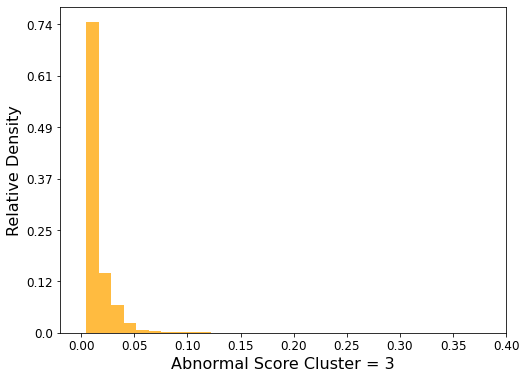

In [49]:
hist, bin_edges = np.histogram(ab_Score_3)
fig, ax = plt.subplots(1,1,figsize=(8, 6))
ax.hist(ab_Score_3,density=False,facecolor='orange',alpha=0.75,bins=100)
ticks =  ax.get_yticks()
ax.tick_params(labelsize=12)
# set labels to absolute values and with integer representation
ax.set_yticklabels([round(tick/len(ab_Score_3),2)for tick in ticks])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0,end, 0.05))
ax.set_xlim((-0.02,0.4))
ax.set_ylabel('Relative Density',fontsize=16)
ax.set_xlabel('Abnormal Score Cluster = 3',fontsize=16)
# sns.distplot(nm_Score, hist=False, bins=19, kde=True,
#             color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              )
# plt.savefig('AB_Score_bar_plot_NOAA_update.png',dpi=600,bbox_inches='tight')
plt.show()

### Impact analysis between number of Clusters and Number of Outliers

In [75]:
kk_test_5 = KMeans(n_clusters=5).fit(test_data_transformed)

In [76]:
kk_test_5.cluster_centers_

array([[0.52763255, 0.49737268, 0.09159515, 0.48090675],
       [0.46694828, 0.50111607, 0.02668689, 0.02838198],
       [0.52814235, 0.50819692, 0.09176535, 0.50199821],
       [0.42788283, 0.53491379, 0.12307538, 0.94807947],
       [0.59354839, 0.82375   , 0.76973705, 0.68942237]])

In [63]:
ab_Score_5 = abScore(test_data_transformed,kk_test_5.labels_,kk_test_5.cluster_centers_)

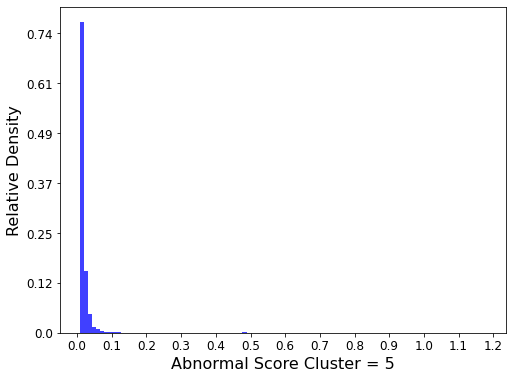

In [93]:
hist, bin_edges = np.histogram(ab_Score_5)
fig, ax = plt.subplots(1,1,figsize=(8, 6))
ax.hist(ab_Score_5,density=False,facecolor='b',alpha=0.75,bins=100)
ticks =  ax.get_yticks()
ax.tick_params(labelsize=12)
# set labels to absolute values and with integer representation
ax.set_yticklabels([round(tick/len(ab_Score_5),2)for tick in ticks])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 0.1))
ax.set_ylabel('Relative Density',fontsize=16)
ax.set_xlabel('Abnormal Score Cluster = 5',fontsize=16)
# sns.distplot(nm_Score, hist=False, bins=19, kde=True,
#             color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              )
# plt.savefig('AB_Score_bar_plot_NOAA.png',dpi=600,bbox_inches='tight')
plt.show()

In [45]:
kk_test_20 = KMeans(n_clusters=20).fit(test_data_transformed)

In [95]:
# kk_test_20.cluster_centers_

array([[0.52610516, 0.50624919, 0.08769301, 0.49814123],
       [0.47220924, 0.50384964, 0.01605052, 0.02816166],
       [0.44132772, 0.51032609, 0.07600477, 0.97233969],
       [0.53238789, 0.51375433, 0.10009864, 0.51125635],
       [0.54480287, 0.23839286, 0.32842116, 0.31702782],
       [0.51154475, 0.50541471, 0.06001915, 0.49622018],
       [0.14814815, 0.62916667, 0.65936342, 0.97545516],
       [0.52397217, 0.52180147, 0.08549481, 0.53046551],
       [0.5131523 , 0.45720339, 0.0845165 , 0.38409333],
       [0.53246815, 0.49867838, 0.10026839, 0.48494926],
       [0.58219065, 0.5059633 , 0.19578168, 0.49793125],
       [0.95519713, 0.696875  , 0.94080141, 0.53561432],
       [0.10394265, 0.3125    , 0.76059641, 0.04358383],
       [0.52494511, 0.49912786, 0.08586179, 0.483562  ],
       [0.52458508, 0.51249805, 0.08506198, 0.51109965],
       [0.53152649, 0.50624935, 0.09806903, 0.49814166],
       [0.48984468, 0.784375  , 0.3239424 , 0.74544036],
       [0.52120348, 0.4874664 ,

In [46]:
ab_Score_20 = abScore(test_data_transformed,kk_test_20.labels_,kk_test_20.cluster_centers_)

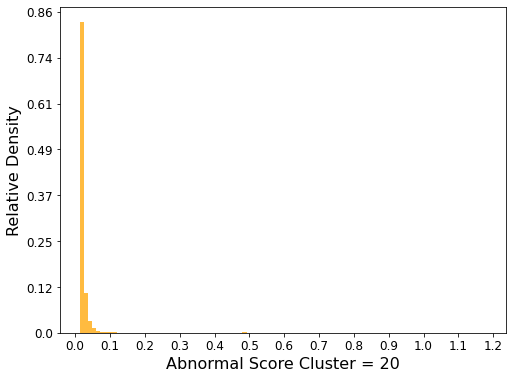

In [97]:
hist, bin_edges = np.histogram(ab_Score_20)
fig, ax = plt.subplots(1,1,figsize=(8, 6))
ax.hist(ab_Score_20,density=False,facecolor='orange',alpha=0.75,bins=100)
ticks =  ax.get_yticks()
ax.tick_params(labelsize=12)
# set labels to absolute values and with integer representation
ax.set_yticklabels([round(tick/len(ab_Score_20),2)for tick in ticks])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 0.1))
ax.set_ylabel('Relative Density',fontsize=16)
ax.set_xlabel('Abnormal Score Cluster = 20',fontsize=16)
# sns.distplot(nm_Score, hist=False, bins=19, kde=True,
#             color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              )
# plt.savefig('AB_Score_bar_plot_NOAA.png',dpi=600,bbox_inches='tight')
plt.show()

In [47]:
kk_test_30 = KMeans(n_clusters=30).fit(test_data_transformed)

In [48]:
# kk_test_30.cluster_centers_

In [49]:
ab_Score_30 = abScore(test_data_transformed,kk_test_30.labels_,kk_test_30.cluster_centers_)

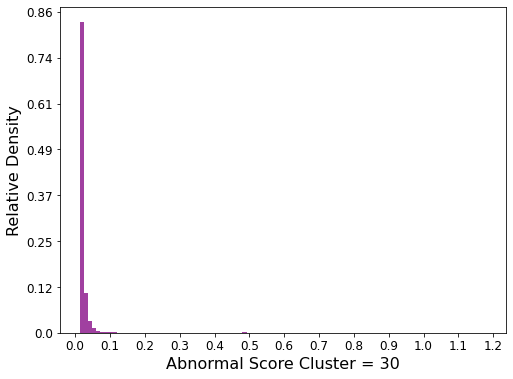

In [138]:
hist, bin_edges = np.histogram(ab_Score_30)
fig, ax = plt.subplots(1,1,figsize=(8, 6))
ax.hist(ab_Score_30,density=False,facecolor='purple',alpha=0.75,bins=100)
ticks =  ax.get_yticks()
ax.tick_params(labelsize=12)
# set labels to absolute values and with integer representation
ax.set_yticklabels([round(tick/len(ab_Score_30),2)for tick in ticks])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 0.1))
ax.set_ylabel('Relative Density',fontsize=16)
ax.set_xlabel('Abnormal Score Cluster = 30',fontsize=16)
# sns.distplot(nm_Score, hist=False, bins=19, kde=True,
#             color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              )
# plt.savefig('AB_Score_bar_plot_NOAA.png',dpi=600,bbox_inches='tight')
plt.show()

In [50]:
kk_test_2= KMeans(n_clusters=2).fit(test_data_transformed)

In [51]:
ab_Score_2 = abScore(test_data_transformed,kk_test_2.labels_,kk_test_2.cluster_centers_)

In [52]:
kk_test_10= KMeans(n_clusters=10).fit(test_data_transformed)
ab_Score_10 = abScore(test_data_transformed,kk_test_10.labels_,kk_test_10.cluster_centers_)

In [53]:
kk_test_15= KMeans(n_clusters=15).fit(test_data_transformed)
ab_Score_15 = abScore(test_data_transformed,kk_test_15.labels_,kk_test_15.cluster_centers_)

In [54]:
kk_test_25= KMeans(n_clusters=25).fit(test_data_transformed)
ab_Score_25 = abScore(test_data_transformed,kk_test_25.labels_,kk_test_25.cluster_centers_)

In [51]:
noaa_t['ab_Score_3']= ab_Score_3

In [77]:
noaa_t['ab_Score_2']= ab_Score_2
noaa_t['ab_Score_5']= ab_Score_5
noaa_t['ab_Score_10']= ab_Score_10
noaa_t['ab_Score_15']= ab_Score_15
noaa_t['ab_Score_20']= ab_Score_20

In [72]:
noaa_t['ab_Score_25']= ab_Score_25

In [65]:
noaa_t['ab_Score_30'] = ab_Score_30

In [155]:
# noaa_t['ab_Score_50'] = ab_Score_50

In [57]:
noaa_t.describe()

lon_diff      lat_diff      v_length       v_angle         ar_no  \
count  40758.000000  40758.000000  40758.000000  40758.000000  40758.000000   
mean      13.250601      0.014819     13.355442     -0.397872  10361.136390   
std        2.590253      1.397789      2.423627     11.837483   1373.491515   
min     -134.000000    -81.000000      0.000000   -178.667780   7933.000000   
25%       13.000000      0.000000     13.000000      0.000000   9170.000000   
50%       13.000000      0.000000     13.038405      0.000000  10350.500000   
75%       14.000000      0.000000     14.000000      0.000000  11560.000000   
max      145.000000     79.000000    145.773797    180.000000  12747.000000   

                idx   labels_test    ab_Score_2    ab_Score_3    ab_Score_5  \
count  40758.000000  40758.000000  40758.000000  40758.000000  40758.000000   
mean       4.603931      0.005005      0.016535      0.016864      0.019837   
std        5.202571      0.080935      0.035995      0.035978      0.035344   
min        0.000000      0.000000      0.004560      0.004854      0.006828   
25%        2.000000      0.000000      0.004560      0.004854      0.009735   
50%        4.000000      0.000000      0.012228      0.012551      0.015306   
75%        7.000000      0.000000      0.019074      0.019642      0.020549   
max      131.000000      2.000000      1.178672      1.178726      1.178774   

        ab_Score_10   ab_Score_15   ab_Score_20   ab_Score_30  
count  40758.000000  40758.000000  40758.000000  40758.000000  
mean       0.022378      0.022760      0.023396      0.023626  
std        0.034972      0.034926      0.034847      0.034834  
min        0.013030      0.013443      0.014081      0.014273  
25%        0.013030      0.013443      0.014081      0.014273  
50%        0.016549      0.017213      0.018524      0.018721  
75%        0.022869      0.022976      0.023862      0.024218  
max        1.178841      1.178865      1.178880      1.178894

In [66]:
noaa_t[noaa_t.ab_Score_3 >=0.1].describe()

lon_diff    lat_diff    v_length     v_angle         ar_no  \
count  354.000000  354.000000  354.000000  354.000000    354.000000   
mean     5.661017    0.183616   14.131990  -51.634093  10832.618644   
std     21.016408   11.451486   20.117623  107.960176   1568.687771   
min   -134.000000  -81.000000    0.000000 -178.667780   7946.000000   
25%     -0.925000   -0.636364    0.941409 -169.286877   9494.250000   
50%      1.000000   -0.175000    7.810250  -38.556759  11489.000000   
75%     13.000000    1.000000   20.760371   31.607502  12113.000000   
max    145.000000   79.000000  145.773797  180.000000  12745.000000   

              idx  labels_test  ab_Score_2  ab_Score_3  ab_Score_5  \
count  354.000000   354.000000  354.000000  354.000000  354.000000   
mean    27.217514     0.576271    0.321737    0.321896    0.322023   
std     37.742915     0.652823    0.195142    0.195019    0.194944   
min      0.000000     0.000000    0.099795    0.100247    0.100351   
25%      3.000000     0.000000    0.125322    0.125525    0.125655   
50%      7.000000     0.000000    0.340180    0.340308    0.340397   
75%     42.750000     1.000000    0.481272    0.481283    0.481320   
max    131.000000     2.000000    1.178672    1.178726    1.178772   

       ab_Score_10  ab_Score_15  ab_Score_20  ab_Score_30  
count   354.000000   354.000000   354.000000   354.000000  
mean      0.322260     0.322339     0.322407     0.322459  
std       0.194834     0.194802     0.194766     0.194740  
min       0.100908     0.101086     0.101214     0.101327  
25%       0.126025     0.126112     0.126228     0.126324  
50%       0.340589     0.340643     0.340687     0.340728  
75%       0.481452     0.481497     0.481531     0.481556  
max       1.178841     1.178865     1.178880     1.178894

In [67]:
noaa_t[noaa_t.ab_Score_2 >=0.1].describe()

lon_diff    lat_diff    v_length     v_angle         ar_no  \
count  353.000000  353.000000  353.000000  353.000000    353.000000   
mean     5.637394    0.161473   14.126345  -51.864628  10832.594901   
std     21.041533   11.460149   20.145898  108.026127   1570.914377   
min   -134.000000  -81.000000    0.000000 -178.667780   7946.000000   
25%     -0.925000   -0.636364    0.941409 -169.286877   9479.000000   
50%      1.000000   -0.175000    7.810250  -38.659808  11489.000000   
75%     13.000000    1.000000   20.808652   31.607502  12113.000000   
max    145.000000   79.000000  145.773797  180.000000  12745.000000   

              idx  labels_test  ab_Score_2  ab_Score_3  ab_Score_5  \
count  353.000000   353.000000  353.000000  353.000000  353.000000   
mean    27.294618     0.577904    0.322365    0.322523    0.322651   
std     37.768560     0.653025    0.195060    0.194938    0.194862   
min      0.000000     0.000000    0.100199    0.100247    0.100351   
25%      3.000000     0.000000    0.125373    0.125525    0.125655   
50%      7.000000     0.000000    0.342508    0.342747    0.342844   
75%     43.000000     1.000000    0.481272    0.481283    0.481320   
max    131.000000     2.000000    1.178672    1.178726    1.178772   

       ab_Score_10  ab_Score_15  ab_Score_20  ab_Score_30  
count   353.000000   353.000000   353.000000   353.000000  
mean      0.322886     0.322965     0.323033     0.323086  
std       0.194753     0.194721     0.194685     0.194659  
min       0.100908     0.101086     0.101214     0.101327  
25%       0.126025     0.126112     0.126228     0.126324  
50%       0.343048     0.343103     0.343145     0.343185  
75%       0.481452     0.481497     0.481531     0.481556  
max       1.178841     1.178865     1.178880     1.178894

In [78]:
noaa_t[noaa_t.ab_Score_5 >=0.1].describe()

lon_diff    lat_diff    v_length     v_angle         ar_no  \
count  357.000000  357.000000  357.000000  357.000000    357.000000   
mean     5.831933    0.190476   14.231882  -51.181684  10823.669468   
std     21.010094   11.403377   20.062128  107.616910   1567.480707   
min   -134.000000  -81.000000    0.000000 -178.667780   7946.000000   
25%     -0.925000   -0.636364    0.941409 -169.286877   9479.000000   
50%      1.000000   -0.175000    7.810250  -37.568592  11486.000000   
75%     13.000000    1.000000   21.260292   31.607502  12113.000000   
max    145.000000   79.000000  145.773797  180.000000  12745.000000   

              idx  labels_test  ab_Score_2  ab_Score_3  ab_Score_5  \
count  357.000000   357.000000  357.000000  357.000000  357.000000   
mean    27.030812     0.571429    0.319870    0.320031    0.320162   
std     37.640249     0.652197    0.195376    0.195253    0.195174   
min      0.000000     0.000000    0.099634    0.099958    0.100351   
25%      3.000000     0.000000    0.125095    0.125141    0.125232   
50%      7.000000     0.000000    0.315504    0.315702    0.315914   
75%     42.000000     1.000000    0.481272    0.481283    0.481320   
max    131.000000     2.000000    1.178672    1.178726    1.178772   

       ab_Score_10  ab_Score_15  ab_Score_20  ab_Score_30  ab_Score_25  
count   357.000000   357.000000   357.000000   357.000000   357.000000  
mean      0.320399     0.320478     0.320547     0.320599     0.320573  
std       0.195065     0.195032     0.194997     0.194970     0.194982  
min       0.100781     0.100984     0.101061     0.101149     0.101112  
25%       0.125683     0.125824     0.125925     0.126021     0.125959  
50%       0.316050     0.316115     0.316136     0.316176     0.316165  
75%       0.481452     0.481497     0.481531     0.481556     0.481543  
max       1.178841     1.178865     1.178880     1.178894     1.178888

In [69]:
noaa_t[noaa_t.ab_Score_10 >=0.1].describe()

lon_diff    lat_diff    v_length     v_angle         ar_no  \
count  397.000000  397.000000  397.000000  397.000000    397.000000   
mean     7.863980    0.171285   15.417587  -46.024839  10674.738035   
std     20.827435   10.812273   19.349750  103.196430   1595.418997   
min   -134.000000  -81.000000    0.000000 -178.667780   7946.000000   
25%     -0.925000   -0.175000    0.941409 -169.286877   9114.000000   
50%      5.000000   -0.175000    9.219544   -6.581945  11160.000000   
75%     24.000000    1.000000   26.000000   20.973493  12113.000000   
max    145.000000   79.000000  145.773797  180.000000  12745.000000   

              idx  labels_test  ab_Score_2  ab_Score_3  ab_Score_5  \
count  397.000000   397.000000  397.000000  397.000000  397.000000   
mean    24.685139     0.513854    0.297631    0.297806    0.297977   
std     36.381038     0.641915    0.196828    0.196703    0.196593   
min      0.000000     0.000000    0.099146    0.099451    0.099975   
25%      3.000000     0.000000    0.112383    0.112899    0.112999   
50%      6.000000     0.000000    0.198879    0.199275    0.199367   
75%     32.000000     1.000000    0.481272    0.481283    0.481320   
max    131.000000     2.000000    1.178672    1.178726    1.178772   

       ab_Score_10  ab_Score_15  ab_Score_20  ab_Score_30  
count   397.000000   397.000000   397.000000   397.000000  
mean      0.298219     0.298312     0.298380     0.298437  
std       0.196490     0.196447     0.196417     0.196389  
min       0.100270     0.100479     0.100537     0.100637  
25%       0.113364     0.113462     0.113631     0.113750  
50%       0.199676     0.199764     0.199829     0.199884  
75%       0.481452     0.481497     0.481531     0.481556  
max       1.178841     1.178865     1.178880     1.178894

In [70]:
noaa_t[noaa_t.ab_Score_15 >=0.1].describe()

lon_diff    lat_diff    v_length     v_angle         ar_no  \
count  397.000000  397.000000  397.000000  397.000000    397.000000   
mean     7.863980    0.171285   15.417587  -46.024839  10674.738035   
std     20.827435   10.812273   19.349750  103.196430   1595.418997   
min   -134.000000  -81.000000    0.000000 -178.667780   7946.000000   
25%     -0.925000   -0.175000    0.941409 -169.286877   9114.000000   
50%      5.000000   -0.175000    9.219544   -6.581945  11160.000000   
75%     24.000000    1.000000   26.000000   20.973493  12113.000000   
max    145.000000   79.000000  145.773797  180.000000  12745.000000   

              idx  labels_test  ab_Score_2  ab_Score_3  ab_Score_5  \
count  397.000000   397.000000  397.000000  397.000000  397.000000   
mean    24.685139     0.513854    0.297631    0.297806    0.297977   
std     36.381038     0.641915    0.196828    0.196703    0.196593   
min      0.000000     0.000000    0.099146    0.099451    0.099975   
25%      3.000000     0.000000    0.112383    0.112899    0.112999   
50%      6.000000     0.000000    0.198879    0.199275    0.199367   
75%     32.000000     1.000000    0.481272    0.481283    0.481320   
max    131.000000     2.000000    1.178672    1.178726    1.178772   

       ab_Score_10  ab_Score_15  ab_Score_20  ab_Score_30  
count   397.000000   397.000000   397.000000   397.000000  
mean      0.298219     0.298312     0.298380     0.298437  
std       0.196490     0.196447     0.196417     0.196389  
min       0.100270     0.100479     0.100537     0.100637  
25%       0.113364     0.113462     0.113631     0.113750  
50%       0.199676     0.199764     0.199829     0.199884  
75%       0.481452     0.481497     0.481531     0.481556  
max       1.178841     1.178865     1.178880     1.178894

In [71]:
noaa_t[noaa_t.ab_Score_20 >=0.1].describe()

lon_diff    lat_diff    v_length     v_angle         ar_no  \
count  397.000000  397.000000  397.000000  397.000000    397.000000   
mean     7.863980    0.171285   15.417587  -46.024839  10674.738035   
std     20.827435   10.812273   19.349750  103.196430   1595.418997   
min   -134.000000  -81.000000    0.000000 -178.667780   7946.000000   
25%     -0.925000   -0.175000    0.941409 -169.286877   9114.000000   
50%      5.000000   -0.175000    9.219544   -6.581945  11160.000000   
75%     24.000000    1.000000   26.000000   20.973493  12113.000000   
max    145.000000   79.000000  145.773797  180.000000  12745.000000   

              idx  labels_test  ab_Score_2  ab_Score_3  ab_Score_5  \
count  397.000000   397.000000  397.000000  397.000000  397.000000   
mean    24.685139     0.513854    0.297631    0.297806    0.297977   
std     36.381038     0.641915    0.196828    0.196703    0.196593   
min      0.000000     0.000000    0.099146    0.099451    0.099975   
25%      3.000000     0.000000    0.112383    0.112899    0.112999   
50%      6.000000     0.000000    0.198879    0.199275    0.199367   
75%     32.000000     1.000000    0.481272    0.481283    0.481320   
max    131.000000     2.000000    1.178672    1.178726    1.178772   

       ab_Score_10  ab_Score_15  ab_Score_20  ab_Score_30  
count   397.000000   397.000000   397.000000   397.000000  
mean      0.298219     0.298312     0.298380     0.298437  
std       0.196490     0.196447     0.196417     0.196389  
min       0.100270     0.100479     0.100537     0.100637  
25%       0.113364     0.113462     0.113631     0.113750  
50%       0.199676     0.199764     0.199829     0.199884  
75%       0.481452     0.481497     0.481531     0.481556  
max       1.178841     1.178865     1.178880     1.178894

In [73]:
noaa_t[noaa_t.ab_Score_25 >=0.1].describe()

lon_diff    lat_diff    v_length     v_angle         ar_no  \
count  397.000000  397.000000  397.000000  397.000000    397.000000   
mean     7.863980    0.171285   15.417587  -46.024839  10674.738035   
std     20.827435   10.812273   19.349750  103.196430   1595.418997   
min   -134.000000  -81.000000    0.000000 -178.667780   7946.000000   
25%     -0.925000   -0.175000    0.941409 -169.286877   9114.000000   
50%      5.000000   -0.175000    9.219544   -6.581945  11160.000000   
75%     24.000000    1.000000   26.000000   20.973493  12113.000000   
max    145.000000   79.000000  145.773797  180.000000  12745.000000   

              idx  labels_test  ab_Score_2  ab_Score_3  ab_Score_5  \
count  397.000000   397.000000  397.000000  397.000000  397.000000   
mean    24.685139     0.513854    0.297631    0.297806    0.297977   
std     36.381038     0.641915    0.196828    0.196703    0.196593   
min      0.000000     0.000000    0.099146    0.099451    0.099975   
25%      3.000000     0.000000    0.112383    0.112899    0.112999   
50%      6.000000     0.000000    0.198879    0.199275    0.199367   
75%     32.000000     1.000000    0.481272    0.481283    0.481320   
max    131.000000     2.000000    1.178672    1.178726    1.178772   

       ab_Score_10  ab_Score_15  ab_Score_20  ab_Score_30  ab_Score_25  
count   397.000000   397.000000   397.000000   397.000000   397.000000  
mean      0.298219     0.298312     0.298380     0.298437     0.298409  
std       0.196490     0.196447     0.196417     0.196389     0.196401  
min       0.100270     0.100479     0.100537     0.100637     0.100595  
25%       0.113364     0.113462     0.113631     0.113750     0.113682  
50%       0.199676     0.199764     0.199829     0.199884     0.199851  
75%       0.481452     0.481497     0.481531     0.481556     0.481543  
max       1.178841     1.178865     1.178880     1.178894     1.178888

In [74]:
noaa_t[noaa_t.ab_Score_30 >=0.1].describe()

lon_diff    lat_diff    v_length     v_angle         ar_no  \
count  397.000000  397.000000  397.000000  397.000000    397.000000   
mean     7.863980    0.171285   15.417587  -46.024839  10674.738035   
std     20.827435   10.812273   19.349750  103.196430   1595.418997   
min   -134.000000  -81.000000    0.000000 -178.667780   7946.000000   
25%     -0.925000   -0.175000    0.941409 -169.286877   9114.000000   
50%      5.000000   -0.175000    9.219544   -6.581945  11160.000000   
75%     24.000000    1.000000   26.000000   20.973493  12113.000000   
max    145.000000   79.000000  145.773797  180.000000  12745.000000   

              idx  labels_test  ab_Score_2  ab_Score_3  ab_Score_5  \
count  397.000000   397.000000  397.000000  397.000000  397.000000   
mean    24.685139     0.513854    0.297631    0.297806    0.297977   
std     36.381038     0.641915    0.196828    0.196703    0.196593   
min      0.000000     0.000000    0.099146    0.099451    0.099975   
25%      3.000000     0.000000    0.112383    0.112899    0.112999   
50%      6.000000     0.000000    0.198879    0.199275    0.199367   
75%     32.000000     1.000000    0.481272    0.481283    0.481320   
max    131.000000     2.000000    1.178672    1.178726    1.178772   

       ab_Score_10  ab_Score_15  ab_Score_20  ab_Score_30  ab_Score_25  
count   397.000000   397.000000   397.000000   397.000000   397.000000  
mean      0.298219     0.298312     0.298380     0.298437     0.298409  
std       0.196490     0.196447     0.196417     0.196389     0.196401  
min       0.100270     0.100479     0.100537     0.100637     0.100595  
25%       0.113364     0.113462     0.113631     0.113750     0.113682  
50%       0.199676     0.199764     0.199829     0.199884     0.199851  
75%       0.481452     0.481497     0.481531     0.481556     0.481543  
max       1.178841     1.178865     1.178880     1.178894     1.178888

In [91]:
set(list(noaa_t[noaa_t.ab_Score_2 >=0.1].index.values)) <= set(list(noaa_t[noaa_t.ab_Score_3 >=0.1].index.values))

True

In [147]:
set(list(noaa_t[noaa_t.ab_Score_5 >=0.1].index.values)) - set(list(noaa_t[noaa_t.ab_Score_3 >=0.1].index.values))

{5242, 15562, 25035}

In [102]:
noaa_t[noaa_t.ab_Score_20 >=0.1].describe()

lon_diff    lat_diff    v_length     v_angle         ar_no  \
count  397.000000  397.000000  397.000000  397.000000    397.000000   
mean     7.863980    0.171285   15.417587  -46.024839  10674.738035   
std     20.827435   10.812273   19.349750  103.196430   1595.418997   
min   -134.000000  -81.000000    0.000000 -178.667780   7946.000000   
25%     -0.925000   -0.175000    0.941409 -169.286877   9114.000000   
50%      5.000000   -0.175000    9.219544   -6.581945  11160.000000   
75%     24.000000    1.000000   26.000000   20.973493  12113.000000   
max    145.000000   79.000000  145.773797  180.000000  12745.000000   

              idx  labels_test  ab_Score_3  ab_Score_5  ab_Score_20  
count  397.000000   397.000000  397.000000  397.000000   397.000000  
mean    24.685139     0.513854    0.297806    0.297975     0.298388  
std     36.381038     0.641915    0.196703    0.196599     0.196405  
min      0.000000     0.000000    0.099451    0.099961     0.100610  
25%      3.000000     0.000000    0.112899    0.113001     0.113628  
50%      6.000000     0.000000    0.199275    0.199376     0.199819  
75%     32.000000     1.000000    0.481283    0.481337     0.481527  
max    131.000000     2.000000    1.178726    1.178772     1.178880

In [159]:
set(list(noaa_t[noaa_t.ab_Score_3 >=0.1].index.values)) <= set(list(noaa_t[noaa_t.ab_Score_20 >=0.1].index.values)) #subset

True

In [152]:
len(set(list(noaa_t[noaa_t.ab_Score_20 >=0.1].index.values)) - set(list(noaa_t[noaa_t.ab_Score_3 >=0.1].index.values)))

43

In [142]:
noaa_t[noaa_t.ab_Score_30 >=0.1].describe()

lon_diff    lat_diff    v_length     v_angle         ar_no  \
count  397.000000  397.000000  397.000000  397.000000    397.000000   
mean     7.863980    0.171285   15.417587  -46.024839  10674.738035   
std     20.827435   10.812273   19.349750  103.196430   1595.418997   
min   -134.000000  -81.000000    0.000000 -178.667780   7946.000000   
25%     -0.925000   -0.175000    0.941409 -169.286877   9114.000000   
50%      5.000000   -0.175000    9.219544   -6.581945  11160.000000   
75%     24.000000    1.000000   26.000000   20.973493  12113.000000   
max    145.000000   79.000000  145.773797  180.000000  12745.000000   

              idx  labels_test  ab_Score_3  ab_Score_5  ab_Score_20  \
count  397.000000   397.000000  397.000000  397.000000   397.000000   
mean    24.685139     0.513854    0.297806    0.297975     0.298388   
std     36.381038     0.641915    0.196703    0.196599     0.196405   
min      0.000000     0.000000    0.099451    0.099961     0.100610   
25%      3.000000     0.000000    0.112899    0.113001     0.113628   
50%      6.000000     0.000000    0.199275    0.199376     0.199819   
75%     32.000000     1.000000    0.481283    0.481337     0.481527   
max    131.000000     2.000000    1.178726    1.178772     1.178880   

       ab_Score_30  
count   397.000000  
mean      0.298432  
std       0.196390  
min       0.100625  
25%       0.113732  
50%       0.199860  
75%       0.481551  
max       1.178893

In [161]:
set(list(noaa_t[noaa_t.ab_Score_3 >=0.1].index.values)) <= set(list(noaa_t[noaa_t.ab_Score_30 >=0.1].index.values))

True

In [166]:
set(list(noaa_t[noaa_t.ab_Score_20 >=0.1].index.values)) == set(list(noaa_t[noaa_t.ab_Score_30 >=0.1].index.values)) #subset



True

In [164]:
set(list(noaa_t[noaa_t.ab_Score_20 >=0.1].index.values)) <= set(list(noaa_t[noaa_t.ab_Score_30 >=0.1].index.values)) #subset


True

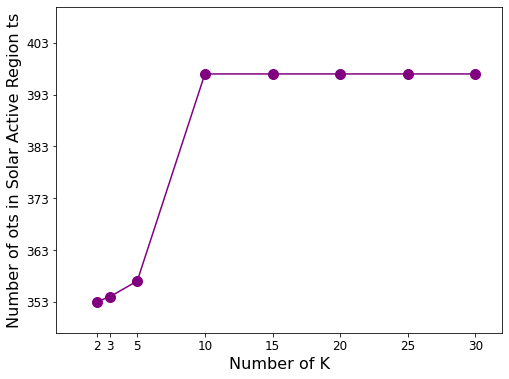

In [161]:
import matplotlib.transforms as mtransforms


K_cluster = np.array([2,3,5,10,15,20,25,30])
out_trj = np.array([353,354,357,397,397,397,397,397])

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,x=-0.3, y=0.20, units='inches')


# for x, y in zip(K_cluster[[0,2,3,4,5,6,7]], out_trj[[0,2,3,4,5,6,7]]):
# #     plt.plot(x, y, 'ro-')
#     plt.text(x, y, '%d' % (int(y)), transform=trans_offset,fontsize = 14)
    
plt.xticks(K_cluster,fontsize = 12)
plt.yticks(np.arange(int(min(out_trj)), int(max(out_trj)+10), 10),fontsize = 12)
plt.xlim(-1,32)
plt.ylim(347,410)
plt.plot(K_cluster, out_trj, 'o-',markersize = 10,color = 'purple')
plt.xlabel('Number of K',fontsize = 16)
plt.ylabel('Number of ots in Solar Active Region ts',fontsize = 16)
# plt.title('Silhouette_score For Optimal k')
plt.savefig('K_AR_ots_update.pdf',bbox_inches='tight')
plt.show()

In [157]:
noaa_t[noaa_t.ab_Score_50 >=0.1].describe()

lon_diff    lat_diff    v_length     v_angle         ar_no  \
count  398.000000  398.000000  398.000000  398.000000    398.000000   
mean     7.891960    0.190955   15.430647  -45.851828  10673.248744   
std     20.808676   10.805775   19.327121  103.124156   1593.685365   
min   -134.000000  -81.000000    0.000000 -178.667780   7946.000000   
25%     -0.925000   -0.175000    0.941409 -169.286877   9118.500000   
50%      5.000000   -0.175000    9.219544   -6.581945  11140.500000   
75%     23.250000    1.000000   26.000000   21.594430  12113.000000   
max    145.000000   79.000000  145.773797  180.000000  12745.000000   

              idx  labels_test  ab_Score_3  ab_Score_5  ab_Score_20  \
count  398.000000   398.000000  398.000000  398.000000   398.000000   
mean    24.628141     0.512563    0.297306    0.297475     0.297889   
std     36.352977     0.641623    0.196709    0.196605     0.196410   
min      0.000000     0.000000    0.098775    0.098982     0.099886   
25%      3.000000     0.000000    0.111650    0.112019     0.112630   
50%      6.000000     0.000000    0.198857    0.199023     0.199469   
75%     31.750000     1.000000    0.481283    0.481337     0.481527   
max    131.000000     2.000000    1.178726    1.178772     1.178880   

       ab_Score_30  ab_Score_50  
count   398.000000   398.000000  
mean      0.297933     0.297986  
std       0.196395     0.196374  
min       0.099948     0.100035  
25%       0.112701     0.112771  
50%       0.199515     0.199563  
75%       0.481551     0.481583  
max       1.178893     1.178905

### AB score threshold equals 0.1 for Cluster = 3

In [52]:
noaa_t[noaa_t.ab_Score_3 <0.1].describe()

lon_diff      lat_diff      v_length       v_angle         ar_no  \
count  40404.000000  40404.000000  40404.000000  40404.000000  40404.000000   
mean      13.317097      0.013340     13.348639      0.051034  10357.005495   
std        1.549211      0.908265      1.544048      4.039610   1370.964336   
min        2.000000     -8.000000      2.000000    -30.256437   7933.000000   
25%       13.000000      0.000000     13.000000      0.000000   9169.000000   
50%       13.000000      0.000000     13.038405      0.000000  10344.500000   
75%       14.000000      0.000000     14.000000      0.000000  11551.000000   
max       26.000000      8.000000     26.019224     30.256437  12747.000000   

                idx  labels_test    ab_Score_3  
count  40404.000000      40404.0  40404.000000  
mean       4.405801          0.0      0.014191  
std        3.215285          0.0      0.012293  
min        0.000000          0.0      0.004854  
25%        2.000000          0.0      0.004854  
50%        4.000000          0.0      0.012551  
75%        7.000000          0.0      0.019642  
max       14.000000          0.0      0.099958

In [53]:
noaa_t[noaa_t.ab_Score_3 >=0.1].describe()

lon_diff    lat_diff    v_length     v_angle         ar_no  \
count  354.000000  354.000000  354.000000  354.000000    354.000000   
mean     5.661017    0.183616   14.131990  -51.634093  10832.618644   
std     21.016408   11.451486   20.117623  107.960176   1568.687771   
min   -134.000000  -81.000000    0.000000 -178.667780   7946.000000   
25%     -0.925000   -0.636364    0.941409 -169.286877   9494.250000   
50%      1.000000   -0.175000    7.810250  -38.556759  11489.000000   
75%     13.000000    1.000000   20.760371   31.607502  12113.000000   
max    145.000000   79.000000  145.773797  180.000000  12745.000000   

              idx  labels_test  ab_Score_3  
count  354.000000   354.000000  354.000000  
mean    27.217514     0.576271    0.321896  
std     37.742915     0.652823    0.195019  
min      0.000000     0.000000    0.100247  
25%      3.000000     0.000000    0.125525  
50%      7.000000     0.000000    0.340308  
75%     42.750000     1.000000    0.481283  
max    131.000000     2.000000    1.178726

In [54]:
noaa_t['AB_label'] = noaa_t.apply(lambda x: 'AB_Score < 0.1' if x.ab_Score_3 < 0.1 else 'AB_Score >= 0.1 cluster '+'{}'.format(x.labels_test),axis=1)


In [55]:
noaa_t[noaa_t.AB_label == 'AB_Score >= 0.1 cluster 2']

lon_diff  lat_diff    v_length     v_angle  \
364       -13.0       0.0   13.000000  180.000000   
365         6.0      34.0   34.525353   79.992020   
1810       -7.0       0.0    7.000000  180.000000   
2246      -22.0      38.0   43.908997  120.068583   
2957       -5.0       1.0    5.099020  168.690068   
3327      -36.0       0.0   36.000000  180.000000   
4024      -29.0       0.0   29.000000  180.000000   
7766     -134.0      53.0  144.100659  158.420094   
9687       -3.5       0.0    3.500000  180.000000   
9688       -3.5       0.0    3.500000  180.000000   
9689       -3.5       0.0    3.500000  180.000000   
9690       -3.5       0.0    3.500000  180.000000   
11934     -71.0       6.0   71.253070  175.169580   
12067      -3.0       2.0    3.605551  146.309932   
16620      -5.0       5.0    7.071068  135.000000   
17278     -73.0       0.0   73.000000  180.000000   
18874     -21.0       0.0   21.000000  180.000000   
20615     -30.0       0.0   30.000000  180.000000   
21039      14.0      61.0   62.585941   77.074001   
21868      -1.0       1.0    1.414214  135.000000   
23061     -27.0       0.0   27.000000  180.000000   
24262      13.0      79.0   80.062476   80.655328   
25081      -8.0       0.0    8.000000  180.000000   
25348      -7.0       4.0    8.062258  150.255119   
25975      -6.0       0.0    6.000000  180.000000   
29926     -17.0       0.0   17.000000  180.000000   
29934      -2.0      14.0   14.142136   98.130102   
29948     -12.0      26.0   28.635642  114.775141   
29982     -14.0       0.0   14.000000  180.000000   
33118      -3.0       0.0    3.000000  180.000000   
37219      -3.0       1.0    3.162278  161.565051   
38708      -1.0       1.0    1.414214  135.000000   

                           v_points  ar_no  idx  labels_test  ab_Score_3  \
364      [-12.0, -2.0, -25.0, -2.0]   7993    4            2    0.511792   
365      [-25.0, -2.0, -19.0, 32.0]   7993    5            2    0.342747   
1810   [-64.0, -24.0, -71.0, -24.0]   8185    0            2    0.510160   
2246      [7.0, -19.0, -15.0, 19.0]   8238    1            2    0.478956   
2957   [-11.0, -23.0, -16.0, -22.0]   8323    4            2    0.479493   
3327   [-35.0, -16.0, -71.0, -16.0]   8366    0            2    0.555329   
4024       [59.0, 22.0, 30.0, 22.0]   8450    3            2    0.536208   
7766     [83.0, -34.0, -51.0, 19.0]   8894    1            2    1.178726   
9687       [82.0, 11.0, 78.5, 11.0]   9114   12            2    0.511161   
9688       [78.5, 11.0, 75.0, 11.0]   9114   13            2    0.511161   
9689       [75.0, 11.0, 71.5, 11.0]   9114   14            2    0.511161   
9690       [71.5, 11.0, 68.0, 11.0]   9114   15            2    0.511161   
11934       [38.0, 3.0, -33.0, 9.0]   9386    2            2    0.700203   
12067      [60.0, 18.0, 57.0, 20.0]   9402    5            2    0.418933   
16620    [39.0, -28.0, 34.0, -23.0]   9927    8            2    0.387030   
17278     [30.0, 18.0, -43.0, 18.0]  10000    6            2    0.718538   
18874        [58.0, 2.0, 37.0, 2.0]  10178    3            2    0.520458   
20615      [66.0, 14.0, 36.0, 14.0]  10378   10            2    0.538647   
21039       [77.0, 5.0, 91.0, 66.0]  10427    4            2    0.553682   
21868    [50.0, -22.0, 49.0, -21.0]  10530    8            2    0.389957   
23061      [78.0, -6.0, 51.0, -6.0]  10669    5            2    0.531636   
24262   [-21.0, -89.0, -8.0, -10.0]  10805    4            2    0.710505   
25081    [20.0, -12.0, 12.0, -12.0]  10907    5            2    0.510139   
25348       [11.0, 10.0, 4.0, 14.0]  10936    4            2    0.428701   
25975      [50.0, 17.0, 44.0, 17.0]  11017    6            2    0.510300   
29926    [2.0, -30.0, -15.0, -30.0]  11489    3            2    0.515211   
29934  [-15.0, -26.0, -17.0, -12.0]  11490    2            2    0.293832   
29948  [-31.0, -40.0, -43.0, -14.0]  11492    1            2    0.385890   
29982   [-6.0, -14.0, -20.0, -14.0]  11495    1      

### Visualize result for NOAA vector

In [119]:
p_normal = np.array([np.array(x) for i,x in enumerate(noaa_t[noaa_t.ab_Score_3 <0.1].v_points.values)])
u = noaa_t[noaa_t.ab_Score_3 <0.1].lon_diff
v = noaa_t[noaa_t.ab_Score_3 <0.1].lat_diff#0.4should be the threadhold

In [120]:
#abnormal cluster 0

In [121]:
p_abnormal_0 = np.array([np.array(x) for i,x in enumerate(noaa_t[noaa_t.AB_label == 'AB_Score >= 0.1 cluster 0'].v_points.values)])
u_ab_0 = noaa_t[noaa_t.AB_label == 'AB_Score >= 0.1 cluster 0'].lon_diff
v_ab_0 = noaa_t[noaa_t.AB_label == 'AB_Score >= 0.1 cluster 0'].lat_diff

In [122]:
#abnormal cluster 1

In [123]:
p_abnormal_1 = np.array([np.array(x) for i,x in enumerate(noaa_t[noaa_t.AB_label == 'AB_Score >= 0.1 cluster 1'].v_points.values)])
u_ab_1 = noaa_t[noaa_t.AB_label == 'AB_Score >= 0.1 cluster 1'].lon_diff
v_ab_1 = noaa_t[noaa_t.AB_label == 'AB_Score >= 0.1 cluster 1'].lat_diff

In [124]:
#abnormal cluster 2

In [125]:
p_abnormal_2 = np.array([np.array(x) for i,x in enumerate(noaa_t[noaa_t.AB_label == 'AB_Score >= 0.1 cluster 2'].v_points.values)])
u_ab_2 = noaa_t[noaa_t.AB_label == 'AB_Score >= 0.1 cluster 2'].lon_diff
v_ab_2 = noaa_t[noaa_t.AB_label == 'AB_Score >= 0.1 cluster 2'].lat_diff

In [126]:
#abnormal cluster all

In [127]:
p_abnormal = np.array([np.array(x) for i,x in enumerate(noaa_t[noaa_t.ab_Score_3 >=0.1].v_points.values)])
u_ab = noaa_t[noaa_t.ab_Score_3 >=0.1].lon_diff
v_ab = noaa_t[noaa_t.ab_Score_3 >=0.1].lat_diff

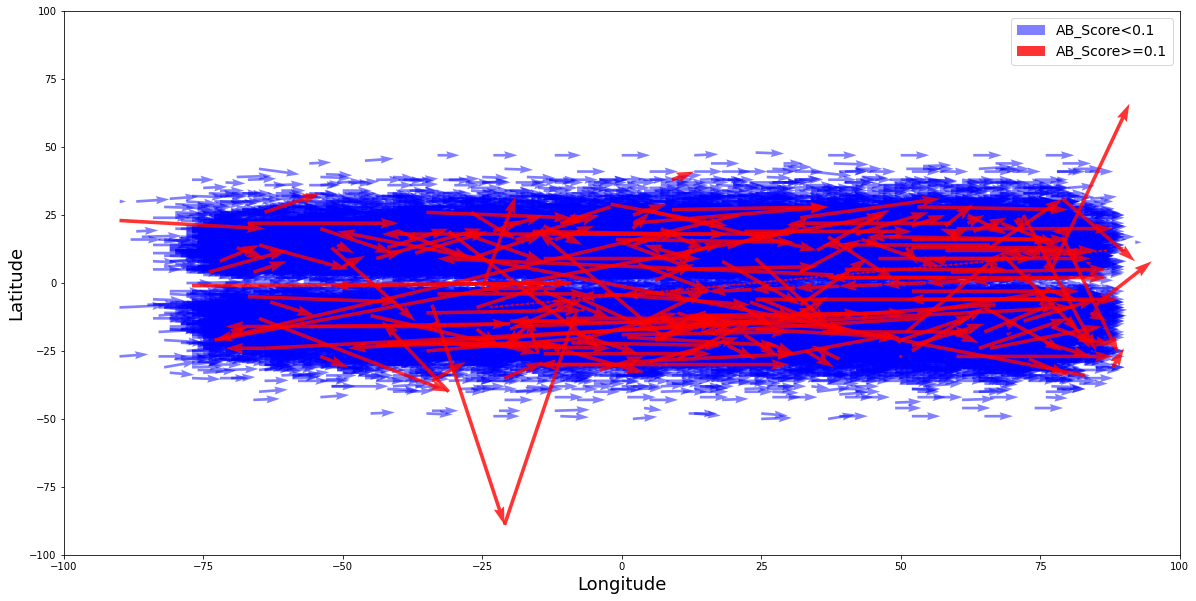

In [129]:
fig =plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)


ax.quiver(p_normal[:,0],p_normal[:,1],u,v,units='xy',angles='xy',color='blue',scale=2,alpha=0.5,label='AB_Score<0.1')
ax.quiver(p_abnormal[:,0],p_abnormal[:,1],u_ab,v_ab,units='xy',angles='xy',color='red',scale_units='xy', scale=1,alpha=0.8,label='AB_Score>=0.1')
    
# ax.quiver(v_position_11492[:,0],v_position_11492[:,1],v_position_11492[:,2],v_position_11492[:,3],units='xy',angles = 'xy',scale=2, color='blue',alpha = 0.5)
ax.set_xlim([-100, 100])
ax.set_ylim([-100, 100])
ax.legend(fontsize =14)
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('')
# plt.savefig('Vector.png',bbox_inches='tight')
plt.show()

### Outlying trajectory segments from three clusters

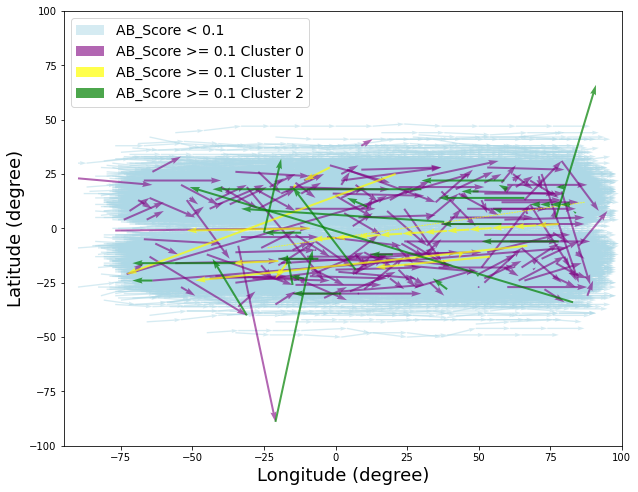

In [178]:
fig =plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)


ax.quiver(p_normal[:,0],p_normal[:,1],u,v,units='xy',angles='xy',color='lightblue',scale_units='xy', scale=1,alpha=0.5,label='AB_Score < 0.1')
ax.quiver(p_abnormal_0[:,0],p_abnormal_0[:,1],u_ab_0,v_ab_0,units='xy',angles='xy',color='purple',scale_units='xy', scale=1,alpha=0.6,width=0.8,label='AB_Score >= 0.1 Cluster 0')
ax.quiver(p_abnormal_1[:,0],p_abnormal_1[:,1],u_ab_1,v_ab_1,units='xy',angles='xy',color='yellow',scale_units='xy', scale=1,alpha=0.7,width=0.8,label='AB_Score >= 0.1 Cluster 1')
ax.quiver(p_abnormal_2[:,0],p_abnormal_2[:,1],u_ab_2,v_ab_2,units='xy',angles='xy',color='green',scale_units='xy', scale=1,alpha=0.7,width=0.8,label='AB_Score >= 0.1 Cluster 2')
    
# ax.quiver(v_position_11492[:,0],v_position_11492[:,1],v_position_11492[:,2],v_position_11492[:,3],units='xy',angles = 'xy',scale=2, color='blue',alpha = 0.5)
ax.set_xlim([-95, 100])
ax.set_ylim([-100, 100])
ax.legend(fontsize =14,loc='upper left')
plt.xlabel('Longitude (degree)',fontsize=18)
plt.ylabel('Latitude (degree)',fontsize=18)
plt.title('')
plt.savefig('NOAA_result.pdf',dpi=600,bbox_inches='tight')
plt.show()